In [1]:
import os
import sys
import yaml
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

sys.path.append(str(Path.cwd().parent / "data"))
sys.path.append(str(Path.cwd().parent / "scripts"))

with open(Path.cwd().parent / 'data/interconnection_helpers.yaml') as f:
    data = yaml.safe_load(f)
    interconnection_mapper = data['interconnection_mapper']
    interconnection_capacities = data['interconnection_capacities']
    interconnection_countries = data['interconnection_countries']
    country_coords = data['country_coords']

from _plotting_helpers import (
    plot_merit_order,
    generation_mix_to_ax
)
from add_electricity import ensure_thermal_supply

with open(Path.cwd().parent / 'config.yaml') as f:
    config = yaml.safe_load(f)

    tech_colors = config['tech_colors']
    nice_names = config['nice_names']

In [2]:
bmus_fn = Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv'
cfd_strike_prices_fn = Path.cwd().parent / 'data' / 'preprocessed' / 'cfd_strike_prices.csv'
roc_values_fn = Path.cwd().parent / 'data' / 'preprocessed' / 'roc_values.csv'
nuclear_marginal_price_fn = Path.cwd().parent / 'data' / 'preprocessed' / 'nuclear_marginal_cost.csv'
battery_phs_capacities_fn = Path.cwd().parent / 'data' / 'preprocessed' / 'battery_phs_capacities.csv'
wholesale_prices_fn = Path.cwd().parent / 'data' / 'preprocessed' / 'thermal_costs' / '2022-week35.csv'

pn_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'physical_notifications.csv')
mel_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'maximum_export_limits.csv')
dah_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'day_ahead_prices.csv')
nemo_powerflow_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'nemo_powerflow.csv')
europe_wholesale_prices_fn = str(Path.cwd().parent / 'data' / 'base' / '{}' / 'europe_day_ahead_prices.csv')

In [3]:
load_weights_fn = Path.cwd().parent / 'data' / 'preprocessed' / 'load_weights.csv'
network_fn = Path.cwd().parent / 'data' / 'raw' / 'lmp_base.nc'

In [4]:
def scale_merit_order(
        n,
        dah,
        collective=False,
        smooth_dah=True,
        ):
    """
    Scale the marginal cost of fossil and biomass generators by the wholesale price

    if collective is True, the scaling factor is uniform over all network snapshots
    and given by the ratio of the 
        weighted average wholesale price to the
        weighted average marginal_cost of the marginal unit.

    if collective is False, the scaling factor is calculated for each period separately.

    smooth_dah applies a smoothing filter to the wholesale price time series
    to prevent erratic behaviour in the marginal cost of the fossil and biomass generators.
    """

    gb_buses = n.buses.loc[n.buses.country == 'GB'].index

    if smooth_dah:
        fig, ax = plt.subplots()
        dah.plot(ax=ax)
        dah = (
            dah.rolling(4, center=True, min_periods=1)
            .mean()
        )
        dah.plot(ax=ax)
        plt.show()

    # technologies that see their marginal price scaled by the wholesale price
    scalers = ['fossil', 'biomass']
    scaling_units = n.generators[n.generators.carrier.isin(scalers)].index

    marginal_unit_cost = pd.Series(np.nan, index=n.snapshots)

    for period, dt in enumerate(n.snapshots):

        ints_marginal_cost = []
        ints_marginal_cap = []
        found_countries = []

        for ic, country in interconnection_countries.items():
            try:

                cost_appendix = n.generators_t.marginal_cost[country.lower() + "_local_market"].iloc[period]
                cap_appendix = n.links.p_nom.loc[ic]

                ints_marginal_cost.append(cost_appendix)
                ints_marginal_cap.append(cap_appendix)

                found_countries.append(country)

            except KeyError:
                continue

        max_avail_gen = pd.concat((
            n.generators.loc[n.generators.bus.isin(gb_buses), ['marginal_cost', 'p_nom', 'carrier']],
            n.storage_units[['marginal_cost', 'p_nom', 'carrier']],
            pd.DataFrame({
                "marginal_cost": ints_marginal_cost,
                'p_nom': ints_marginal_cap,
                'carrier': ['interconnector'] * len(ints_marginal_cost)
                }, index=found_countries)
        ))

        intermittents = n.generators_t.p_max_pu.columns.intersection(max_avail_gen.index)
        max_avail_gen.loc[intermittents, "p_nom"] *= n.generators_t.p_max_pu[intermittents].iloc[period]

        max_avail_gen = max_avail_gen.sort_values(by=['marginal_cost', 'carrier'])

        max_avail_gen['cum_p_nom'] = max_avail_gen['p_nom'].cumsum()

        load = n.loads_t.p_set[gb_buses].iloc[period].sum()
        marginal_unit = max_avail_gen[max_avail_gen['cum_p_nom'] > load].iloc[0].name
        mc = max_avail_gen.loc[marginal_unit, 'marginal_cost']

        if isinstance(mc, pd.Series): 
            mc = mc.iloc[0]

        marginal_unit_cost.loc[dt] = mc

        if not collective:

            if mc <= 1 or dah.iloc[period, 0] <= 1:
                scaling_factor = 1.
            else:
                scaling_factor = dah.iloc[period, 0] / mc

            new_marginal_cost_units = (
                scaling_units
                .difference(n.generators_t.marginal_cost.columns) 
            )

            n.generators_t.marginal_cost = pd.concat((
                n.generators_t.marginal_cost,
                pd.DataFrame(0., index=n.snapshots, columns=new_marginal_cost_units)
            ), axis=1)

            n.generators_t.marginal_cost.loc[n.snapshots[period], scaling_units] = (
                n.generators.loc[scaling_units, 'marginal_cost'] * scaling_factor
            )

    if not collective:
        return

    # calculate the scaling factor
    total_demand = n.loads_t.p_set[gb_buses].sum(axis=1)

    weighted_avg_mc = (marginal_unit_cost * total_demand).sum() / total_demand.sum()
    weighted_avg_dah = (dah.iloc[:, 0] * total_demand).sum() / total_demand.sum()

    if weighted_avg_mc <= 1 or weighted_avg_dah <= 1:
        scaling_factor = 1.
    else:
        scaling_factor = weighted_avg_dah / weighted_avg_mc

    n.generators.loc[scaling_units, 'marginal_cost'] *= scaling_factor


C:\Users\lukas\AppData\Local\Temp\ipykernel_17212\3009476432.py:499: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(cfd_strike_prices_fn, index_col=0, parse_dates=True)
INFO:pypsa.io:Imported network lmp_base.nc has buses, lines, links, transformers


Adding load...
Adding 105 onwind generators...
Adding 79 offwind generators...
Adding 2 solar generators...
Adding 8 nuclear generators...
Adding 108 thermal generators...
Adding 64 battery storage units...
Adding 17 PHS storage units...
Adding 7 cascade generators...
Adding 17 hydro generators...
Adding 9 interconnectors...
No interconnector flow data for EastWest
No interconnector flow data for Moyle



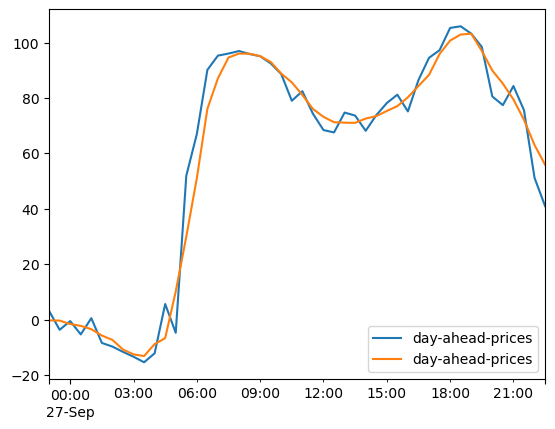

In [5]:
def add_wind(
        n,
        bmus,
        pn,
        mel,
        cfds,
        rocs,
        carrier=None,
    ):

    plants = (
        bmus[bmus['carrier'] == carrier]
        .index
        .intersection(pn.columns)
    )

    print(f'Adding {len(plants)} {carrier} generators...')

    n.add(
        "Generator",
        plants,
        bus=bmus.loc[plants, 'bus'],
        carrier=carrier,
        p_nom=pn[plants].max(),
        marginal_cost=np.nan,
        efficiency=1,
        p_max_pu=pn[plants].div(pn[plants].max()).replace(np.nan, 0),
    )

    roc_generators = rocs.index.intersection(plants)
    n.generators.loc[roc_generators, 'marginal_cost'] = - rocs[roc_generators]

    cfd_generators = cfds.index.intersection(plants)
    n.generators.loc[cfd_generators, 'marginal_cost'] = 0.


def add_onshore_wind(*args):
    add_wind(*args, carrier='onwind')


def add_offshore_wind(*args):
    add_wind(*args, carrier='offwind')


def add_solar(
        n,
        bmus,
        pn,
    ):

    plants = (
        bmus[bmus['carrier'] == 'solar']
        .index
        .intersection(pn.columns)
    )

    print(f'Adding {len(plants)} solar generators...')

    n.add(
        "Generator",
        plants,
        bus=bmus.loc[plants, 'bus'],
        carrier='solar',
        p_nom=pn[plants].max(),
        marginal_cost=0.,
        efficiency=1,
        p_max_pu=pn[plants].div(pn[plants].max()).replace(np.nan, 0),
    )


def add_nuclear(
        n,
        bmus,
        pn,
        nuclear_wholesale_price,
    ):

    plants = bmus[bmus['carrier'] == 'nuclear'].index

    # some nuclear-labelled BMUs always import electricity
    # these are thrown out
    plants = plants.intersection(pn.columns[pn.mean() > 0])

    print(f'Adding {len(plants)} nuclear generators...')
    n.add(
        "Generator",
        plants,
        bus=bmus.loc[plants, 'bus'],
        carrier='nuclear',
        p_nom=pn[plants].max(),
        marginal_cost=nuclear_wholesale_price,
        efficiency=1,
    )

    # For nuclear units that are not constant, a 'p_max_pu' is needed
    for plant in plants:
        if len(pn[plant].unique()) > 1:
            n.generators_t['p_max_pu'].loc[:,plant] = pn[plant].div(pn[plant].max())


def add_thermal(
        n,
        bmus,
        pn,
        mel,
        wholesale_prices,
    ):

    plants = (
        bmus[bmus['carrier'].isin(['biomass', 'fossil'])]
        .index
        .intersection(pn.columns)
        .intersection(mel.columns)
    )
    print(f'Adding {len(plants)} thermal generators...')

    missing = plants.difference(wholesale_prices.index)
    print(f'Warning: Filling in wholesale prices for {", ".join(missing)}')

    # wholesale_prices.loc[missing] = wholesale_prices.mean()
    wholesale_prices = pd.concat((
        wholesale_prices,
        pd.Series(wholesale_prices.mean(), index=missing)
    ))

    # assert plants.isin(wholesale_prices.index).all(), 'Missing wholesale prices for some thermal plants.'    

    p_max_pu = mel[plants].div(mel[plants].max()).replace(np.nan, 0)

    # Elexon Maximum Export Limit is sometimes missing data for thermal units
    # in this case, all p_max_pu are 0 right now, causing a shortage of power supply.
    # To deal with this, in the respective timesteps, they are set to 1 instead.
    fix_mask = (p_max_pu == 0).all(axis=1)

    if fix_mask.any():
        print(f'Fixing {fix_mask.sum()} timesteps with missing thermal generation data.')
        p_max_pu.loc[fix_mask] = 1.

    n.add(
        "Generator",
        plants,
        bus=bmus.loc[plants, 'bus'],
        carrier=bmus.loc[plants, 'carrier'],
        p_nom=mel[plants].max(),
        marginal_cost=wholesale_prices.loc[plants],
        p_max_pu=p_max_pu,
    )


def add_temporal_flexibility(
        n,
        bmus,
        pn,
        mel,
        battery_phs_capacities,
        carrier='battery',
        ):

    # data shows that flexible assets are not used to their full potential
    # due to usage in other markets or myopic foresight.
    # To account for this, the storage capacity is reduced by a factor.
    damping_factor = 0.25

    assets = bmus[bmus['carrier'] == carrier].index

    assets = assets.intersection(pn.columns).intersection(mel.columns)

    print(f'Adding {len(assets)} {carrier} storage units...')
    # times two because time step is 30 minutes and max_hours does not
    # refer to hours but time steps within the context of the network's
    # time scale
    max_hours = (
        battery_phs_capacities['energy_cap[MWh]']
        .div(battery_phs_capacities['power_cap[MW]'])
        .mul(2.)
    )

    n.add(
        "StorageUnit",
        assets,
        bus=bmus.loc[assets, 'bus'],
        carrier=carrier,
        p_nom=battery_phs_capacities.loc[assets, 'power_cap[MW]'] * damping_factor,
        max_hours=max_hours.loc[assets],
        marginal_cost=0.,
        cyclic_state_of_charge=True,
        # e_cyclic=True,
        # state_of_charge_initial=(
        #     battery_phs_capacities
        #     .loc[assets, 'energy_cap[MWh]']
        #     .div(3.) # start at 1/3 of capacity based on typical overnight charging
        # ),
    )


def add_pumped_hydro(*args):
    add_temporal_flexibility(*args, carrier='PHS')


def add_batteries(*args):
    add_temporal_flexibility(*args, carrier='battery')


def add_hydropower(
        n,
        bmus,
        pn,
        roc_values, 
        carrier='hydro',
    ):

    assets = (
        bmus[bmus['carrier'] == carrier]
        .index
        .intersection(pn.columns)
    )

    print(f'Adding {len(assets)} {carrier} generators...')

    if carrier == 'cascade':
        marginal_costs = - roc_values.loc[assets]
    elif carrier == 'hydro':
        marginal_costs = 0.

    n.add(
        "StorageUnit",
        assets,
        bus=bmus.loc[assets, 'bus'],
        carrier=carrier,
        p_nom=pn[assets].max(),
        marginal_cost=marginal_costs,
        e_cyclic=False,
        state_of_charge_initial=pn[assets].sum(),
        max_hours=pn[assets].sum().div(pn[assets].max()),
        p_min_pu=0.,
    )

    # causes infeasibility, unclear why it can happen
    n.remove('StorageUnit', n.storage_units.index[n.storage_units.state_of_charge_initial < 0.])


def add_cascade(*args):
    add_hydropower(*args, carrier='cascade')


def add_dispatchable_hydro(*args):
    add_hydropower(*args, carrier='hydro')
    

def add_interconnectors(
        n,
        bmus,
        pn,
        europe_wholesale_prices,
        nemo,
        interconnection_mapper,
        interconnection_capacities,
        interconnection_countries,
        fixed_ic,
        country_coords,
    ):

    print(f'Adding {len(interconnection_mapper)} interconnectors...')

    for (ic, ic_bmunits) in interconnection_mapper.items():

        p_nom = interconnection_capacities[ic]
        country = interconnection_countries[ic]
        marginal_cost = europe_wholesale_prices.loc[:, country]

        # no data for Nemo at the moment
        if ic == 'Nemo':

            link_kwargs = {
                'bus1': '4975',
            }

            if fixed_ic:
                link_kwargs.update({
                    'p_set': nemo.iloc[:,0]
                })
            else:
                rr = nemo.iloc[:,0].diff().dropna().abs().max()
                link_kwargs.update({
                    'ramp_rate_up': rr,
                    'ramp_rate_down': rr,
                })
            p_nom = max(p_nom, nemo.iloc[:,0].abs().max())

        else:
            inter_flow = bmus.loc[
                bmus.index.str.contains('|'.join(ic_bmunits)),
                'bus']

            if inter_flow.empty:
                print('No interconnector flow data for', ic)
                continue

            gb_bus = inter_flow.value_counts().index[0]

            flow = (
                pn[pn.columns[pn.columns.str.contains('|'.join(ic_bmunits))]]
                .sum(axis=1)
            )

            p_nom = max(p_nom, flow.abs().max())
            link_kwargs = {
                'bus1': gb_bus,
                }

            if fixed_ic:
                link_kwargs.update({
                    'p_set': flow
                })
            else:
                rr = flow.diff().dropna().abs().max()
                link_kwargs.update({
                    'ramp_rate_up': rr,
                    'ramp_rate_down': rr,
                })

            if (flow == 0).all():
                print('No interconnector flow data for', ic)
                continue

        # this setup simulates a local market for each country that
        # can either be supplied by local generators (if the local wholesale
        # price is lower than GB wholesale price) or by GB generators
        # via the interconnector (if the GB wholesale price is lower)
        if not country in n.buses.index:
            n.add(
                'Bus',
                country,
                carrier='electricity',
                x=country_coords[country][0],
                y=country_coords[country][1],
                country=country,
                )
            n.add(
                "Load",
                country.lower() + '_local_market',
                bus=country,
                p_set=pd.Series(0, index=pn.index),
                carrier=country,
                )
            n.add(
                "Generator",
                country.lower() + '_local_market',
                bus=country,
                p_nom=0.,
                marginal_cost=marginal_cost,
                carrier="local_market",
                )

        n.add(
            "Link",
            ic,
            bus0=country,
            p_nom=p_nom,
            efficiency=0.99,
            p_max_pu=1.,
            p_min_pu=-1.,
            carrier='interconnector',
            **link_kwargs,
            )

        n.generators.loc[country.lower() + '_local_market', 'p_nom'] += 2 * p_nom
        n.loads_t.p_set.loc[:, country.lower() + '_local_market'] += (
            pd.Series(p_nom, index=pn.index)
        )


def build_static_supply_curve(
        n,
        bmus,
        pn,
        mel,
        wholesale_prices,
        europe_wholesale_prices,
        nemo,
        cfd_strike_prices,
        roc_values,
        nuclear_wholesale_price,
        battery_phs_capacities,
        interconnection_mapper,
        interconnection_capacities,
        interconnection_countries,
        fixed_ic,
        country_coords,
    ):
    """
    Builds one day of available power plants, storage units and their marginal costs.
    It is 'static' in not scaling marginal costs according to wholesale price (yet).
    """

    n.generators.loc[:, 'marginal_cost'] = np.nan
    n.storage_units.loc[:, 'marginal_cost'] = np.nan

    add_onshore_wind(n, bmus, pn, mel, cfd_strike_prices, roc_values)
    add_offshore_wind(n, bmus, pn, mel, cfd_strike_prices, roc_values)
    add_solar(n, bmus, pn)
    add_nuclear(n, bmus, pn, nuclear_wholesale_price)
    add_thermal(n, bmus, pn, mel, wholesale_prices)
    add_batteries(n, bmus, pn, mel, battery_phs_capacities)
    add_pumped_hydro(n, bmus, pn, mel, battery_phs_capacities)
    add_cascade(n, bmus, pn, roc_values)
    add_dispatchable_hydro(n, bmus, pn, roc_values)
    add_interconnectors(
        n,
        bmus,
        pn,
        europe_wholesale_prices,
        nemo,
        interconnection_mapper,
        interconnection_capacities,
        interconnection_countries,
        fixed_ic,
        country_coords
        )

    print('')


def add_load(n, pns, weights, nemo):

    # subtract for interconnector export
    real_int_flow = pd.DataFrame(index=n.snapshots)

    for name, bmu_names in interconnection_mapper.items():
        if name == 'Nemo':
            real_int_flow[name] = nemo.iloc[:,0]

        else:
            real_int_flow[name] = (
                pn[pn.columns[pn.columns.str.contains('|'.join(bmu_names))]]
                .sum(axis=1)
            )

    export = real_int_flow.clip(upper=0).sum(axis=1).mul(-1)

    assert (export >= 0).all(), 'Interconnector export should be negative.'

    # subtract charging of temporal flexibility assets
    storages = n.storage_units.index.intersection(pns.columns)
    charging = pns[storages].clip(upper=0).sum(axis=1).mul(-1)

    assert (charging >= 0).all(), 'Charging should be negative.'

    net_load = pn.clip(lower=0).sum(axis=1) - export - charging

    print('Adding load...')

    p_set = pd.DataFrame(
        np.outer(net_load, weights['load_weight']),
        index=n.snapshots,
        columns=weights.index
        )

    n.add(
        "Load",
        weights.index,
        bus=weights.index,
        p_set=p_set,
        carrier='electricity',
    )


def add_carriers(n, bmus, interconnection_countries):
    n.add("Carrier", bmus['carrier'].unique())
    n.add("Carrier", "load")
    n.add("Carrier", "electricity")
    n.add("Carrier", "local_market")
    n.add("Carrier", list(set(interconnection_countries.values())))


if __name__ == '__main__':

    # day = '2024-03-21'
    day = '2024-09-27'

    pn = pd.read_csv(pn_fn.format(day), index_col=0, parse_dates=True)
    mel = pd.read_csv(mel_fn.format(day), index_col=0, parse_dates=True)
    dah = pd.read_csv(dah_fn.format(day), index_col=0, parse_dates=True)
    europe_wholesale_prices = pd.read_csv(europe_wholesale_prices_fn.format(day), index_col=0, parse_dates=True)
    nemo = pd.read_csv(nemo_powerflow_fn.format(day), index_col=0, parse_dates=True)

    pn.index = pn.index.values
    mel.index = mel.index.values
    europe_wholesale_prices.index = europe_wholesale_prices.index.values
    dah.index = dah.index.values
    nemo.index = nemo.index.values

    wholesale_prices = (
        pd.read_csv(wholesale_prices_fn, index_col=0)
        .iloc[:,0]
    )

    cfd_strike_prices = (
        pd.read_csv(cfd_strike_prices_fn, index_col=0, parse_dates=True)
        .loc[:, :day]
        .iloc[:, -1]
        .rename('cfd_strike_price')
    )

    roc_values = (
        pd.read_csv(roc_values_fn, index_col=0)
        .iloc[:,0]
        .rename('roc_value')
    )

    nuclear_wholesale_price = pd.read_csv(nuclear_marginal_price_fn, index_col=0).iloc[0,0]
    battery_phs_capacities = pd.read_csv(battery_phs_capacities_fn, index_col=0)

    fixed_ic = False

    # n = pypsa.Network()
    n = pypsa.Network(network_fn)
    weights = pd.read_csv(load_weights_fn, index_col=0)
    weights.index = weights.index.astype(str)

    bmus = pd.read_csv(bmus_fn, index_col=0)
    bmus['bus'] = bmus['bus'].astype(str)

    add_carriers(n, bmus, interconnection_countries)

    n.set_snapshots(pn.index)

    add_load(n, pn, weights, nemo)

    build_static_supply_curve(
        n,
        bmus,
        pn,
        mel,
        wholesale_prices,
        europe_wholesale_prices,
        nemo,
        cfd_strike_prices,
        roc_values,
        nuclear_wholesale_price,
        battery_phs_capacities,
        interconnection_mapper,
        interconnection_capacities,
        interconnection_countries,
        fixed_ic,
        country_coords,
        )

    m = n.generators_t.marginal_cost 

    scale_merit_order(n, dah, collective=False)

    #remove_all_interconnectors(n)
    #remove_all_storage(n)


In [6]:
n.optimize()

Index(['8009', '8708', '8706'], dtype='object', name='Link')
Index(['11524', '8702', '8704', '8703', '14745', '2144', '6084', '6125',
       '11733', '11729',
       ...
       '11519', '5187', '5203', '11517', '5218', '6216', '6218', '8126',
       '8125', '5185'],
      dtype='object', name='Line', length=460)
Index(['15756', '15757', '15758', '15787', '15788', '15789', '15790', '15791',
       '15792', '15793', '15794', '15795', '15796', '15797', '15798', '15799',
       '15800', '15910', '15911', '15912', '15913', '15914', '15915', '15916',
       '15917', '15918', '15919', '15920', '15921', '15922', '15923', '15924',
       '15925', '15926', '15927', '15928', '15929', '15930', '15931', '15932',
       '15933', '15934', '15935', '15936', '15937', '15938', '15939', '15940',
       '16000', '16001', '16002', '16003', '16004', '16005', '16006'],
      dtype='object', name='Transformer')
Index(['8838', '8013', '8520', '8649', '4950', '4951', '4952', '4953', '4954',
       '4955',
     

('ok', 'optimal')

<Axes: xlabel='snapshot'>

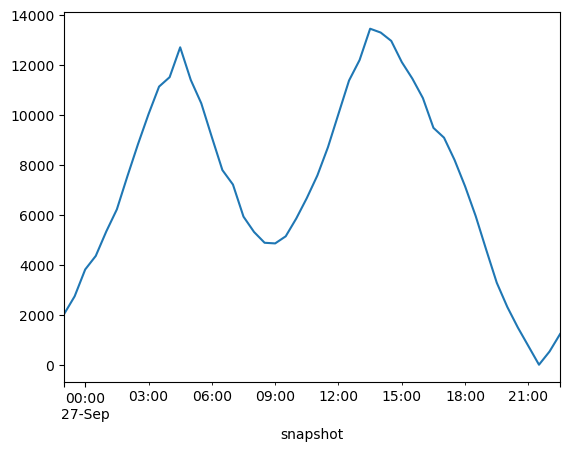

In [7]:
flex = n.storage_units.loc[n.storage_units.carrier.isin(['PHS', 'battery'])].index
n.storage_units_t.state_of_charge.loc[:, flex].sum(axis=1).plot()

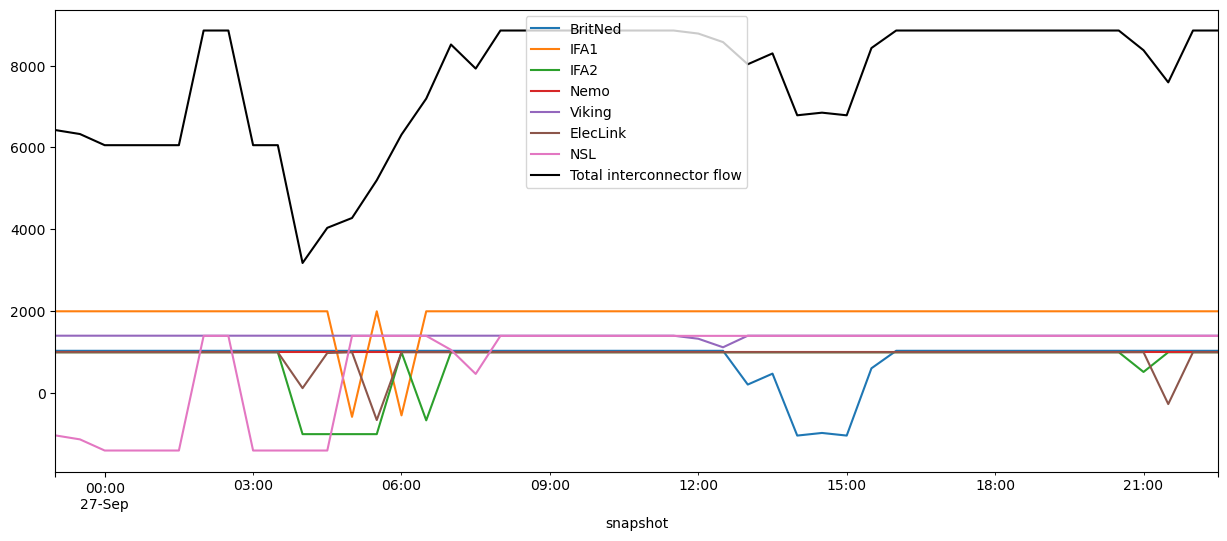

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))

# n.links_t.p0.plot(ax=ax)
# n.links_t.p0.sum(axis=1).plot(ax=ax, color='k', label='Total interconnector flow')

l = n.links_t.p0
l = l[l.columns.intersection(list(interconnection_mapper))]

l.plot(ax=ax)
l.sum(axis=1).plot(ax=ax, color='k', label='Total interconnector flow')

ax.legend()
plt.show()

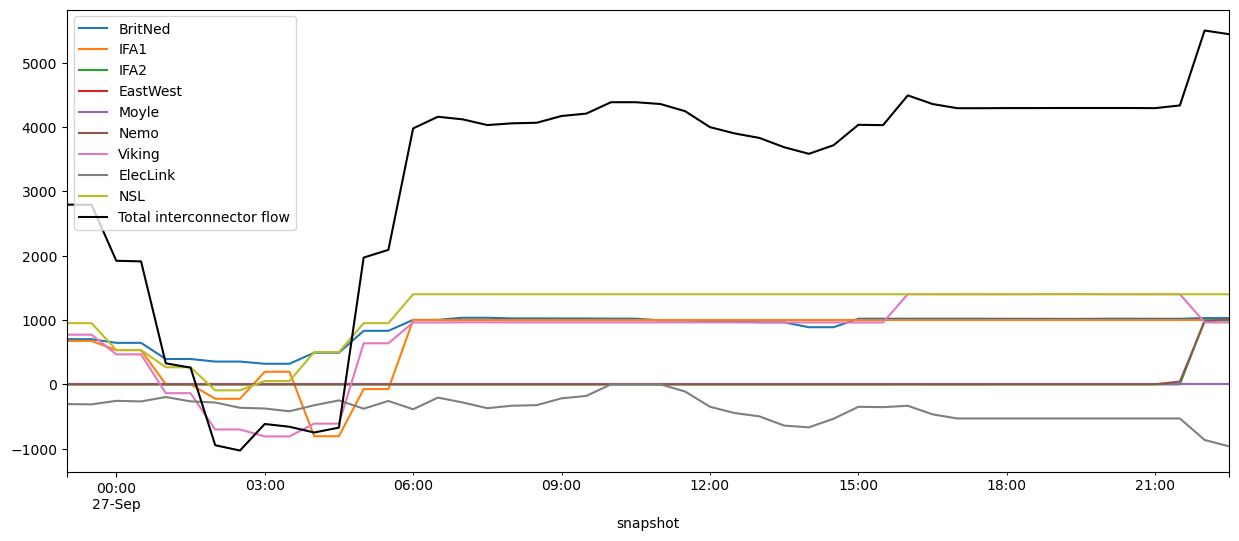

In [9]:
real_int_flow = pd.DataFrame(index=n.snapshots)
interconnector_bmus = []

for name, bmu_names in interconnection_mapper.items():

    if name == 'Nemo':
        real_int_flow[name] = nemo.iloc[:,0]
        continue

    current_bmus = pn.columns[pn.columns.str.contains('|'.join(bmu_names))]
    interconnector_bmus.extend(current_bmus)
    real_int_flow[name] = pn[current_bmus].sum(axis=1)


fig, ax = plt.subplots(figsize=(15, 6))

real_int_flow.plot(ax=ax)
real_int_flow.sum(axis=1).plot(ax=ax, color='k', label='Total interconnector flow')

ax.legend()
plt.show()

In [10]:
for ic, country in interconnection_countries.items():
    print(ic, country)

IFA1 France
Moyle Ireland
BritNed Netherlands
IFA2 France
EastWest Ireland
Viking Denmark
ElecLink France
NSL Norway
Nemo Belgium


In [11]:
for i, country in n.links.loc[n.links['carrier'] == 'interconnector', 'bus0'].items():
    print(i, country)

BritNed Netherlands
IFA1 France
IFA2 France
Nemo Belgium
Viking Denmark
ElecLink France
NSL Norway


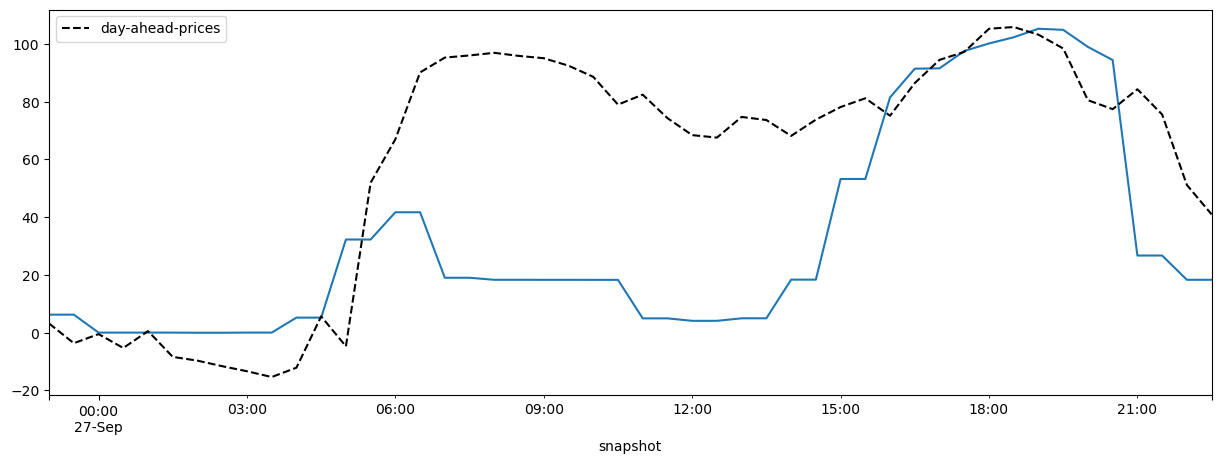

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))

n.buses_t.marginal_price.mean(axis=1).plot(ax=ax)
dah.plot(ax=ax, color='black', linestyle='--')

plt.show()

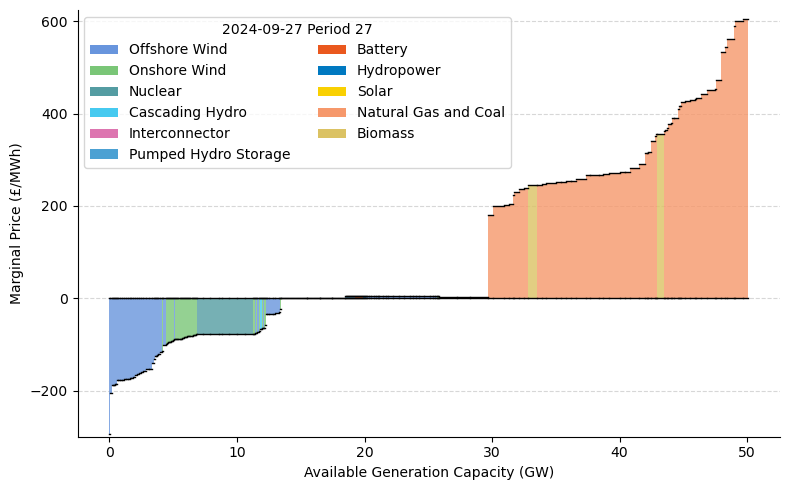

In [14]:
period = 27
plot_merit_order(n, period , f'merit_order_{day}_{period}.pdf')